# Preliminary Results on the NIX Detector Properties

Notes:
- It is somewhat concerning (especially at this stage) that we are getting preprocessed images instead of individual readouts. Discussed this with William. He believes there is a way to get invidual readouts but he wasn't sure.
- There are two fairly large bad pixel clumps in the detector. This essentially makes those regions unusable. Also discussed this with William. He thinks dithering should help avoiding bad pixels. It is somewhat observation dependent but I agree. 
- Low signals are undersampled in gain and linearity calculations. A more appropriate dataset should be taken and the calculations should be revisited in the future.  
- Exposure times are very short to determine the dark current. 

Includes:
- A crude Bad Pixel mask
- Linearity solution
- Gain calculation
- Readout Noise


There is probably a fudge factor in gain and read noise depending on how the readouts are performed. Looking at the header information, I suspect 3 independent integrations are used to generate images. Hence (if my assumption is true), I underestimate the variance by a factor of 3. Relevant header info from one of the fits files:

```
HIERARCH ESO DET ID          = 'MTF' / Detector system Id                       
HIERARCH ESO DET NAME        = 'H2RG-5um-NIX' / Name of detector system         
HIERARCH ESO DET NDIT        = 3 / Number of Sub-Integrations                   
HIERARCH ESO DET NDITSKIP    = 0 / DITs skipped at 1st.INT                      
HIERARCH ESO DET NDSAMPLES   = 2 / Number of Non-Destructive Samples            
HIERARCH ESO DET NDSKIP      = 0 / Samples skipped per DIT                      
HIERARCH ESO DET NSAMPPIX    = 8 / Number of samples on each pixel              
HIERARCH ESO DET READ CURID  = 3 / Used readout mode id                         
HIERARCH ESO DET READ CURNAME= 'SLOW_LR_CDS' / Used readout mode name           
HIERARCH ESO DET SEQ BREAK   = F / Break enabled                                
HIERARCH ESO DET SEQ UTC     = '2019-08-27T15:37:28.4581' / Sequencer Start Time
HIERARCH ESO DET SEQ1 CONT   = T / Continuous mode active                       
HIERARCH ESO DET SEQ1 CVTEXT = T / External convert active                      
HIERARCH ESO DET SEQ1 DIT    = 4.000000 / [s] Integration time                  
HIERARCH ESO DET SEQ1 EXPTIME= 17.5850940 / [s] Exposure Sequence Time          
HIERARCH ESO DET SEQ1 INITTIME= 0.0000000 / [s] Exposure Init Time              
HIERARCH ESO DET SEQ1 MINDIT = 1.6116980 / [s] Minimum DIT                      
HIERARCH ESO DET SEQ1 PERIOD = 0.0000000 / [s] Trigger period                   
HIERARCH ESO DET SEQ1 REALDIT= 4.0000000 / [s] Actual integration time    
```

In [1]:
from NIX_Testing import NIX_Image_List, NIX_Image, doGridAnalysis
from pylab import *
from astropy.io import fits
from lmfit.models import PolynomialModel
import pickle

data_dir = '/home/ydallilar/Documents/NIX/nixDetBackup'

test_ids = ['PER-124-04-1']
config = {'test_ids' : test_ids, 'data_dir' : data_dir}
NIX_GL = NIX_Image_List(config)

/home/ydallilar/.miniconda2/envs/py3/lib/python3.6/site-packages/scipy/__init__.py:115: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.11.3)
  UserWarning)


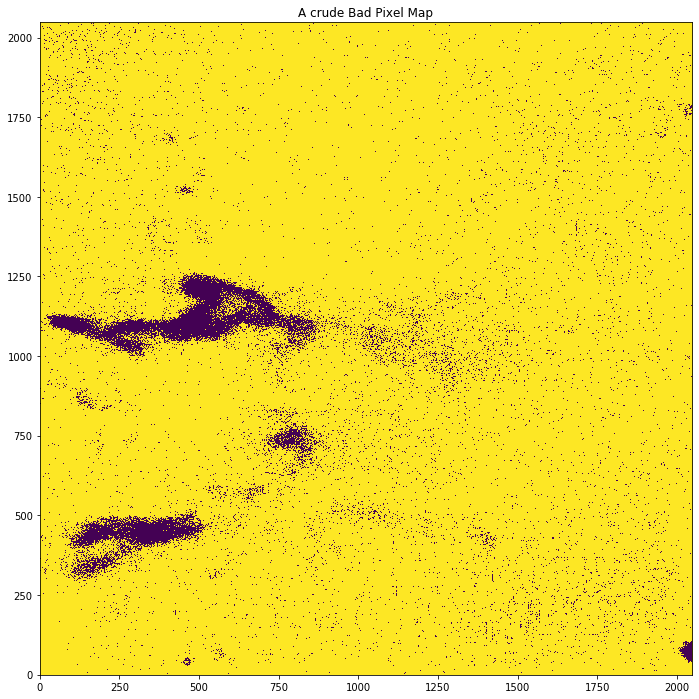

In [2]:
BP_Mask = NIX_Image('BP_mask.fits')
figure(figsize=(12, 12))
title("A crude Bad Pixel Map")
BP_Mask.plotImage()


In [3]:
sz = len(NIX_GL)//2

ims = zeros([2048, 2048, sz//2])
diffs = zeros([2048, 2048, sz//2])

for i in range(sz//2):
    ims[:,:,i] = NIX_GL[2*i+40].getImage(mask=BP_Mask, dark=NIX_GL[2*i])
    diffs[:,:,i] = NIX_GL[2*i+41].getImage(mask=BP_Mask)-NIX_GL[2*i+40].getImage(mask=BP_Mask)

ims[where(ims == 0)] = NaN
diffs[where(diffs == 0)] = NaN


[ 1  2  3 ..., 18 19 20]


Text(0.5, 0, 'Apparent Signal (ADU)')

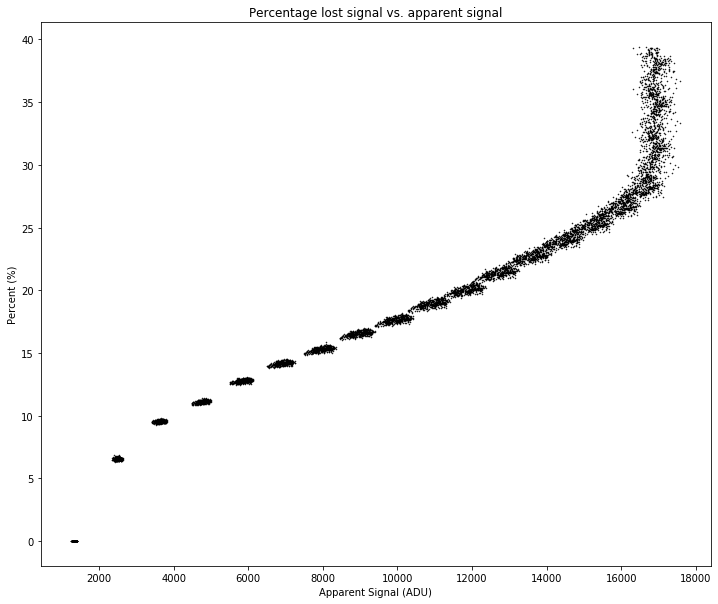

In [4]:
signals = []
true_signal = []

exps = (arange(20)+1)*2

grid = 20
window = 50
start = 500
factor = tile(arange(sz//2)+1, grid*grid)
print(factor)


true_signal = doGridAnalysis(ims, grid, window, start, nanmedian, factor=factor, index=0)
signals = doGridAnalysis(ims, grid, window, start, nanmedian)

figure(figsize=(12,10))
plot(signals, (1-signals/true_signal)*100., 'k.', markersize=1.)
title("Percentage lost signal vs. apparent signal")
ylabel("Percent (%)")
xlabel("Apparent Signal (ADU)")


[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 12
    # data points      = 6286
    # variables        = 4
    chi-square         = 24242589.529
    reduced chi-square = 3859.056
    Akaike info crit   = 51914.905
    Bayesian info crit = 51941.889
[[Variables]]
    c0:   0 (fixed)
    c1:   0.98859245 +/- 0.001760 (0.18%) (init= 1.090812)
    c2:   3.8303e-05 +/- 5.84e-07 (1.52%) (init= 1.709866e-05)
    c3:  -2.5914e-09 +/- 6.05e-11 (2.34%) (init=-8.871764e-10)
    c4:   1.0421e-13 +/- 1.97e-15 (1.89%) (init= 5.754065e-14)
[[Correlations]] (unreported correlations are <  0.100)
    C(c3, c4)                    = -0.993 
    C(c2, c3)                    = -0.987 
    C(c1, c2)                    = -0.970 
    C(c2, c4)                    =  0.960 
    C(c1, c3)                    =  0.920 
    C(c1, c4)                    = -0.872 



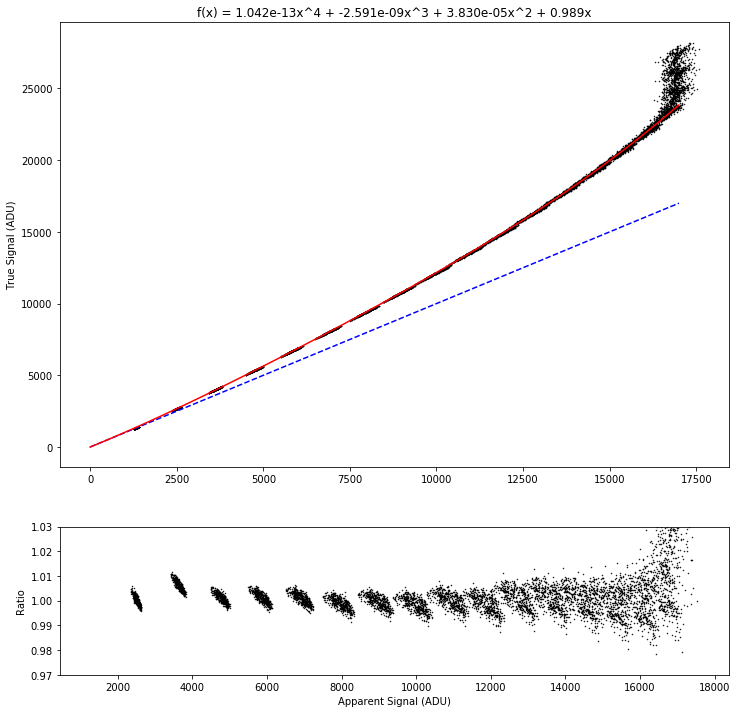

In [5]:
order = 4

ndx = where(signals < 16000)[0]

model = PolynomialModel(order)
pars = model.guess(true_signal[ndx], x=signals[ndx])
pars['c0'].set(value=0., vary=False)

out = model.fit(true_signal[ndx], pars, x=signals[ndx])

print(out.fit_report())


pol = poly1d([out.best_values['c%d' % i] for i in range(order+1)[::-1]])
outfile = open('linearity_coef', 'wb')
pickle.dump(pol.coeffs, outfile)
outfile.close()

xx = linspace(0, 17000, 100)

f, (a1, a2) = subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12,12))

a1.plot(signals, true_signal, 'k.', markersize=1.)
a1.plot(xx, xx, 'b--')
a1.plot(xx, pol(xx), 'r-')
a1.set_ylabel('True Signal (ADU)')
a1.set_title('f(x) = %.3ex^4 + %.3ex^3 + %.3ex^2 + %.3fx' % \
             tuple([out.best_values['c%d' % i ] for i in range(1,5)[::-1]]))

a2.plot(signals, true_signal/pol(signals), 'k.', markersize=1.)
a2.set_ylabel('Ratio')
a2.set_xlabel('Apparent Signal (ADU)')
a2.set_ylim([0.97, 1.03])

show()


In [6]:
for i in range(sz//2):
    ims[:,:,i] = NIX_GL[2*i+40].getImage(mask=BP_Mask, dark=NIX_GL[2*i], linearize=pol)
    diffs[:,:,i] = NIX_GL[2*i+41].getImage(mask=BP_Mask, dark=NIX_GL[2*i], linearize=pol) \
                -NIX_GL[2*i+40].getImage(mask=BP_Mask, dark=NIX_GL[2*i], linearize=pol)    
    
ims[where(ims == 0)] = NaN
diffs[where(diffs == 0)] = NaN

stds = doGridAnalysis(diffs, grid, window, start, nanstd, factor=1./sqrt(2))
signals = doGridAnalysis(ims, grid, window, start, nanmedian)

ndx = where(array(signals) < 16000)[0]

In [7]:
im1 = NIX_GL[48].getImage(dark=NIX_GL[8])#, linearize=pol)
im2 = NIX_GL[58].getImage(dark=NIX_GL[18])#, linearize=pol)
fits.PrimaryHDU(im2).writeto("out/test1.fits", overwrite=True)

im1 = NIX_GL[48].getImage(dark=NIX_GL[8], linearize=pol)
im2 = NIX_GL[58].getImage(dark=NIX_GL[18], linearize=pol)
fits.PrimaryHDU(im2).writeto("out/test2.fits", overwrite=True)

fits.PrimaryHDU(im2/im1/2.).writeto("out/test.fits", overwrite=True)


/home/ydallilar/.miniconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/ydallilar/.miniconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [8]:
order = 1

log_signal = log10(signals)
log_std = log10(stds)

model = PolynomialModel(order)
pars = model.guess(log_std[ndx], x=log_signal[ndx])
pars['c1'].set(value=0.5, vary=False)

out = model.fit(log_std[ndx], pars, x=log_signal[ndx])

print out.fit_report()

xx = linspace(3, 4.4, 100)
pol = poly1d([out.best_values['c%d' % i] for i in range(order+1)[::-1]])


plt.figure(figsize=(12,10))
plot(log_signal[ndx], log_std[ndx], 'k.', markersize=1.)
plot(xx, pol(xx), 'r-')
ylabel('log(noise)')
xlabel('log(signal)')

gain1 = 10**(-out.best_values['c0']*2)

print("Gain : %.1f e-/ADU" % gain1)
print("Taking the fudge factor into account")
print("Gain : %.1f e-/ADU" % (gain1/3.))

show()


SyntaxError: invalid syntax (<ipython-input-8-59e8851726a7>, line 12)

In [ ]:
order = 1

vars = array(stds)**2
signals = array(signals)

model = PolynomialModel(order)
pars = model.guess(signals[ndx], x=vars[ndx])
pars['c0'].set(value=0., vary=False)

out = model.fit(signals[ndx], pars, x=vars[ndx])

print(out.fit_report())

xx = linspace(0, 1000, 100)
pol = poly1d([out.best_values['c%d' % i] for i in range(order+1)[::-1]])

plt.figure(figsize=(12,10))
plot(vars[ndx], signals[ndx], 'k.', markersize=1.)
#plot(vars[ndx], signals[ndx], 'r.', markersize=1.)
plot(xx, pol(xx), 'r-')
ylabel('Signal')
xlabel('Variance')
plt.xlim([-100, 1500])

gain2 = out.best_values['c1']

print("Gain : %.1f e-/ADU" % (gain2))
print("Taking the fudge factor into account")
print("Gain : %.1f e-/ADU" % (gain2/3.))

In [ ]:
ims = zeros([2048, 2048, sz//2])
diffs = zeros([2048, 2048, sz//2])

for i in range(sz//2):
    ims[:,:,i] = NIX_GL[2*i].getImage(mask=BP_Mask)-NIX_GL[0].getImage(mask=BP_Mask)
    diffs[:,:,i] = NIX_GL[2*i+1].getImage(mask=BP_Mask)-NIX_GL[2*i].getImage(mask=BP_Mask)

ims[where(ims == 0)] = NaN
diffs[where(diffs == 0)] = NaN

stds = doGridAnalysis(diffs, grid, window, start, nanstd, factor=1./sqrt(2))
signals = doGridAnalysis(ims, grid, window, start, nanmedian)
exps = tile(arange(sz//2)*2+2, grid*grid)


In [ ]:
stds_r = stds.reshape([400, sz//2])
RNs = median(stds_r, axis=0)
RN_std = std(stds_r, axis=0)
exp_r = exps.reshape([400, sz/2/])

figure(figsize=(12,10))
plot(exp_r[0,:], RNs, 'k.')
ylabel('Read Noise (ADU)')
xlabel('Exposure Time (s)')

print "Read Noise : %.2f +/- %.2f ADU (or %.2f +/- %.2f e-)" % (mean(RNs), std(RNs), gain1*mean(RNs), gain1*std(RNs)) 
print "Taking the fudge factor into account"
print "Read Noise : %.2f +/- %.2f ADU (or %.2f +/- %.2f e-)" % \
    (mean(RNs)*sqrt(3), std(RNs)*sqrt(3), gain1*mean(RNs)/sqrt(3), gain1*std(RNs)/sqrt(3)) 